# Using *ceffyl* on a PTA free spectrum

A free spectrum of the PTA is easy to refit spectra using *ceffyl*. Simply choose your spectrum from *ceffyl.model* (or create your own function!), along with the number of frequencies that you want to search over, and let your MCMC run!

First off, let's import some required packages...

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from chainconsumer.chainconsumer import ChainConsumer
from ceffyl import gfl, model
from enterprise.signals import parameter

import la_forge.core as co

##### PTA free spectrum

The free spectrum is a model-independent analysis of the timing residuals from the PTA [(Lentati et. al. 2013)](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.87.104021). For a PTA free spectrum, we typically model 30 frequency power-laws for each pulsar's intrinsic red noise, as well as a common free-spectrum process instead of an e.g power-law common process. We recover posteriors at each sampled GW frequency that represents the common process' cross-power spectrum at that frequency bin. The posteriors are represented by the coefficient $\rho$, where $$\rho(f_k) = \prod_{a,b}\frac{\Gamma_{ab}S_{ab}(f_k)}{T} = \prod_a\frac{S_{aa}(f_k)}{T}$$ for a pulsar $a$ at a frequency bin $f_k$ for $k \in [1, N_k]$, $S$ is the timing-residual cross-power spectrum, $T$ is the PTA timing baseline, and $\Gamma_{ab}=\delta_{ab}$ is the overlap reduction function between pulsars $a$ and $b$, which we assume to be independent, hence the Dirac delta function.

We run the free spectrum with [`enterprise`](https://github.com/nanograv/enterprise). NOTE: `enterprise` defines $\rho$ differently to the above and within the literature, such that $\rho_\mathrm{enterprise}=\sqrt{\rho}$. With this definiton, $\rho_\mathrm{enterprise}$ has units of seconds and represents the timing residual delay.

Let's see what the free spectrum looks like for a simulated pulsar timing array (simulation based on [Pol et. al. 2021](http://dx.doi.org/10.3847/2041-8213/abf2c9))

In [2]:
freespec = co.Core(corepath='../data/sim0/fs10f_real_0.core')

Loading data from HDF5 file....


Text(0, 0.5, '$\\log_{10}$ CP delay [s]')

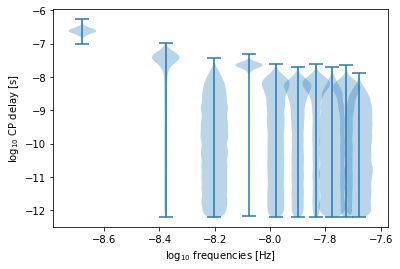

In [3]:
plt.violinplot(pd.DataFrame(freespec(freespec.params[-15:-5])),
               positions=np.log10(freespec.rn_freqs),
               widths=0.1)
plt.xlabel('$\log_{10}$ frequencies [Hz]')
plt.ylabel(r'$\log_{10}$ CP delay [s]')

### Now let's fit some GW models!

To fit our GW models onto our free spectrum, we must represent our posteriors as probability density functions in order to extract probabilities to build a Bayesian likelihood. Using the most optimal kernel density estimators (KDEs, see paper for details), we can create a grid of probabilities to select from.

For details on creating your own probability grids, see [link to another ipynb being developed]. However, these grids will be made for you in advance for most PTA data sets so all you have to do is use them! :)

In [4]:
# let's initialise a GFL object with a directory containing the KDE densities of our simulated PTA free spectrum
refitter = gfl.GFL('../data/sim0/spsr_densities/')

Now let's add a GW spectrum! Let's try a 10f powerlaw. The default parameters here are $\log_{10}A\in[-18,-12]$, $\gamma\in[0,7]$

In [5]:
gw = gfl.signal(psd=model.powerlaw, N_freqs=10)

Now let's setup and run our sampler

In [6]:
signals = [gw]
sampler = refitter.setup_sampler(signals=signals,
                                 outdir='../data/sim0/refits/10fpl/',
                                 logL=refitter.ln_likelihood,
                                 logp=refitter.ln_prior)
x0 = refitter.initial_samples()  # get initial sample

Adding GWB uniform distribution draws...



In [ ]:
sampler.sample(x0, int(1e6))  # sample!

##### Let's read the data

In [7]:
c0 = co.Core('../data/sim0/refits/10fpl/')
c0.set_rn_freqs(Tspan=1/freespec.rn_freqs[0], nfreqs=10)
c0.save('../data/sim0/refits/10fpl/chain.core')
pl10f = co.Core(corepath='../data/sim0/refits/10fpl/chain.core')

/Users/lambwg/Applications/miniconda3/envs/enterprise/lib/python3.9/site-packages/la_forge/core.py:149: UserWarning: loadtxt: Empty input file: "../data/sim0/refits/10fpl/draw_from_gwb_log_uniform_dist_jump.txt"
  self.jumps[ky] = np.loadtxt(path, dtype=float)
/Users/lambwg/Applications/miniconda3/envs/enterprise/lib/python3.9/site-packages/la_forge/core.py:149: UserWarning: loadtxt: Empty input file: "../data/sim0/refits/10fpl/draw_from_prior_jump.txt"
  self.jumps[ky] = np.loadtxt(path, dtype=float)


Loading data from HDF5 file....


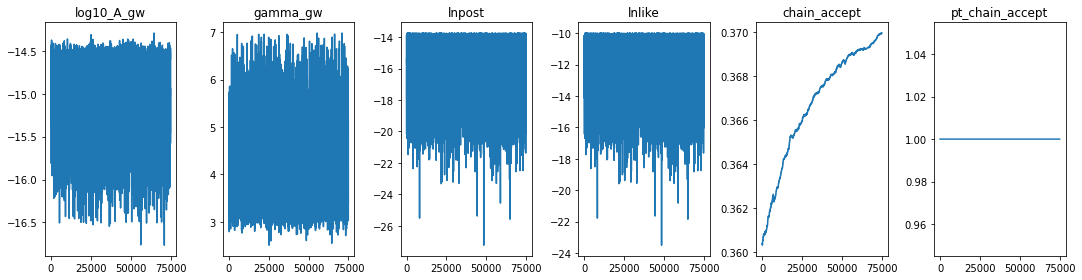

In [8]:
# checking the traceplots
fig, axs = plt.subplots(ncols=len(pl10f.params), tight_layout=True,
                        figsize=(15,4))
for ii, p in enumerate(pl10f.params):
    ax = axs[ii]
    ax.plot(pl10f(p))
    ax.set_title(p)

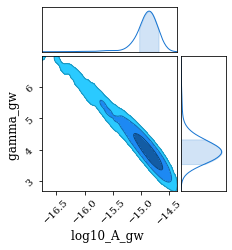

In [9]:
# let's make a corner plot!
c = ChainConsumer()
c.add_chain(pl10f(pl10f.params[:2]), parameters=pl10f.params[:2])
c.configure(usetex=False, summary=False, sigmas=[1,2,3])
c.plotter.plot();

Let's see how well that went... Let's take the maximum likelihood parameters from this run and plot it on the free spectrum

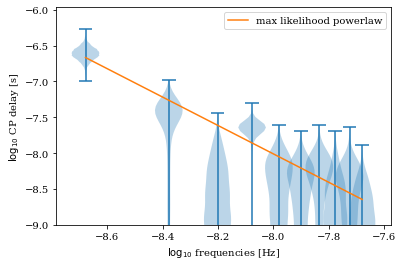

In [17]:
idx = np.where(pl10f('lnpost').max()==pl10f('lnpost'))[0][0]
log10_A, gamma = pl10f.chain[pl10f.burn:][idx][:2]

pl = 0.5*np.log10(model.powerlaw(pl10f.rn_freqs, log10_A=log10_A,
                                 gamma=gamma))

plt.violinplot(pd.DataFrame(freespec(freespec.params[-15:-5])),
               positions=np.log10(freespec.rn_freqs),
               widths=0.1)
plt.plot(np.log10(pl10f.rn_freqs), pl, label='max likelihood powerlaw')
plt.xlabel('$\log_{10}$ frequencies [Hz]')
plt.ylabel(r'$\log_{10}$ CP delay [s]')
plt.ylim(-9)
plt.legend();

##### What if I want to try a different model?

Then just change the model function... All models supported right now are found in `ceffyl.model`. *These are equivalent to the functions in `enterprise.gp_priors`, except they're faster as the don't require repeated frequencies and they are vectorised. Note that the functions in `enterprise.gp_priors` will not work with `ceffyl`.*

What about a broken powerlaw with fixed $\gamma=13/3$?

In [10]:
# first we need to define some priors on log10_A and the break frequency, log10_fb
# it's just like defining priors in a standard enterprise run!
params = [parameter.Uniform(-18, -12)('log10_A'),
          parameter.Uniform(-9, -7)('log10_fb')]

# then we define gamma as a constant float
const_params = dict(gamma=13/3)

# then we choose our model
psd = model.broken_powerlaw

In [11]:
# and the create our signal!
gw = gfl.signal(N_freqs=10, psd=psd, params=params,
                const_params=const_params)

In [ ]:
# and finally, we setup the sampler!
signals = [gw]
sampler = refitter.setup_sampler(signals=signals,
                                 outdir='../data/sim0/refits/10fbpl/',
                                 logL=refitter.ln_likelihood,
                                 logp=refitter.ln_prior)
x0 = refitter.initial_samples()  # get initial sample
sampler.sample(x0, int(1e6))